# Try gaussian regression on parameters of a synthetic data set

In [2]:
# Import packages
import numpy as np

# Import Gaussian-regression related functions
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


# Load training and testing data

In [33]:
# Load training data set
import scipy.io as sio
loaded = sio.loadmat("./data/trainGrid.mat")
U = loaded['Us']
Y = loaded['observations']

# Pre-process the data
from sklearn import preprocessing
U_scaler = preprocessing.StandardScaler()
U_scaler.fit(U)
U_scaled = U_scaler.transform(U)

Y_scaler = preprocessing.StandardScaler()
Y_scaler.fit(Y)
Y_scaled = Y_scaler.transform(Y)

# Load testing data set
import scipy.io as sio
loaded = sio.loadmat("./data/testGrid.mat")
U_test = loaded['Us']
Y_test = loaded['observations']

U_test_scaled = U_scaler.transform(U_test)
Y_test_scaled = Y_scaler.transform(Y_test)

In [34]:
# Train the gaussian_process
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(U_scaled, Y_scaled)
gaussian_process.kernel_

0.954**2 * RBF(length_scale=0.609)

In [35]:
# Calculate U_plot
minU = np.min(U, axis = 0)
maxU = np.max(U, axis = 0)
nOfGridPoints = 100

xis = []
for i in range(minU.shape[0]):
    xis.append(np.linspace(minU[i], maxU[i], nOfGridPoints))

# Generate grid and draw predictions
UPlotGrid = np.meshgrid(xis[0], xis[1])
UPlotGrid = np.stack(UPlotGrid, axis = 2)
UPlotGridFat = UPlotGrid.reshape([nOfGridPoints * nOfGridPoints, maxU.shape[0]])
UPlotGridFat_scaled = U_scaler.transform(UPlotGridFat)
YPlotGridFat_scaled = gaussian_process.predict(UPlotGridFat_scaled)
YPlotGrid_scaled = YPlotGridFat_scaled.reshape([nOfGridPoints, nOfGridPoints, Y_scaled.shape[1]])


In [36]:
YPlotGrid_scaled.shape

(100, 100, 12)

# Plot the predicted distribution for a test data point

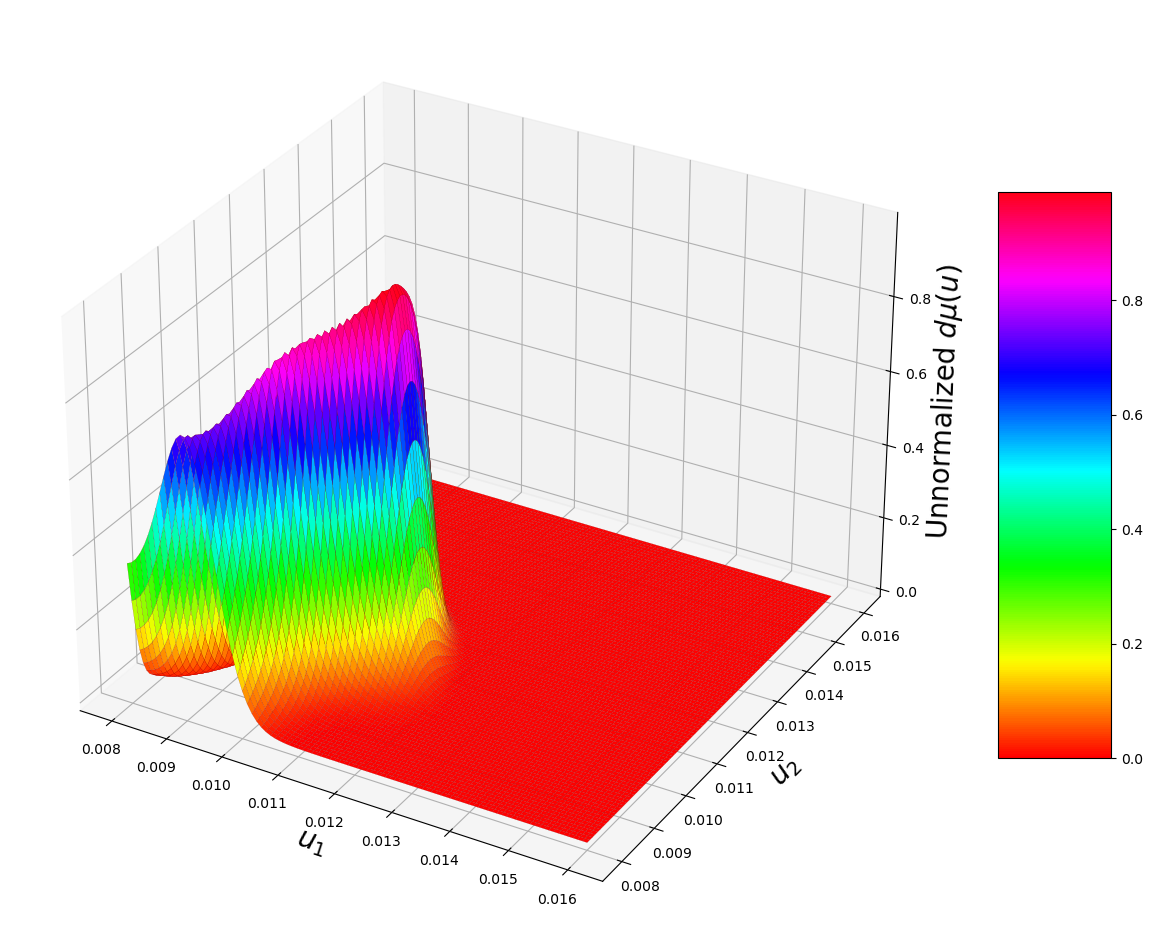

In [66]:
# Test
test_idx = 0
u = U_test_scaled[test_idx, :]
y = Y_test_scaled[test_idx, :]
si_eta = 0.5

# Compute \Phi(u) = \|y - G_N(u)\|^2
PhiPlot_grid = np.linalg.norm(y - YPlotGrid_scaled, axis = 2) ** 2

# Compute pdf(u) = exp(-\Phi(u))
pdf_grid = np.exp(-PhiPlot_grid / si_eta)

# Plot figure
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (15, 15), dpi = 100)

# Plot the surface.
# surf = ax.plot_surface(UPlotGrid[:, :, 0], UPlotGrid[:, :, 1], pdf_grid, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

surf = ax.plot_surface(UPlotGrid[:, :, 0], UPlotGrid[:, :, 1], pdf_grid, rstride=1, cstride=1, cmap=cm.hsv, \
  edgecolor='darkred', linewidth=0.1)

ax.set_xlabel('$u_1$', fontsize = 20)
ax.set_ylabel('$u_2$', fontsize = 20)
ax.set_zlabel('Unnormalized $d\mu(u)$', fontsize = 20)

# plt.scatter(U.reshape([-1]), np.linalg.norm(y - Y, axis = 1) ** 2)

# # Customize z axis
# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [67]:
ind = np.unravel_index(np.argmax(pdf_grid, axis=None), pdf_grid.shape)
ind

(36, 37)

In [68]:
UPlotGrid[ind]

array([0.0109899 , 0.01090909])

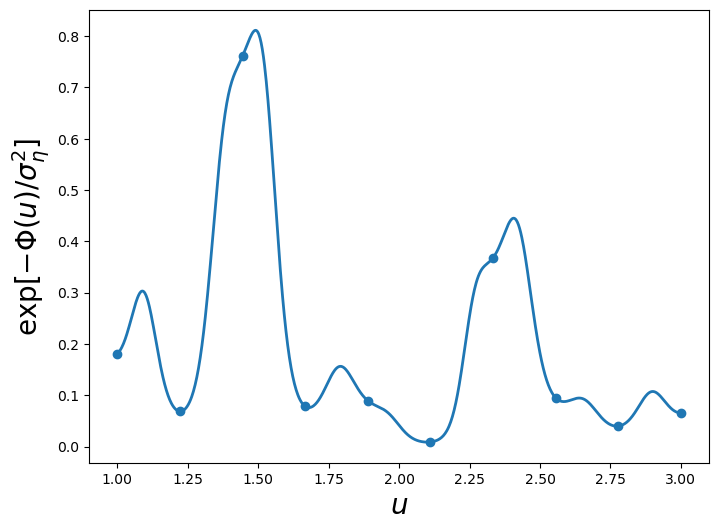

In [72]:
# Plot unnormalized PDF of u
# Set sigma_eta
si_eta = 1.

PDF_plot = np.exp(-Phi_plot / si_eta ** 2 / 2)

plt.figure(figsize=(8, 6), dpi = 100)
from matplotlib import pyplot as plt
plt.plot(u_plot, PDF_plot, linewidth = 2.0)
plt.xlabel('$u$', fontsize = 20)
plt.ylabel('$\exp[-\\Phi(u) / \\sigma_{\\eta}^2]$', fontsize = 20)

PDF_scatter = np.exp(-np.linalg.norm(y - Y, axis = 1) ** 2 / si_eta ** 2 / 2)

plt.scatter(U.reshape([-1]), PDF_scatter)